In [1]:
import tensornetwork as tn
import numpy as np
import torch as tc
from tensornetwork.visualization.graphviz import to_graphviz
tn.set_default_backend("pytorch")
state =  tn.Node(tc.tensor([1. + 0.j, 0. + 0.j], dtype=tc.complex128))    # Rank-1 tensor

In [2]:
qubit = state[0]    # which represents an edge of tensor

In [3]:
# This node represents the Hardmard gate we wish to perform
hardmard = tn.Node(tc.tensor([[1, 1], [1, -1]], dtype=tc.complex128) / np.sqrt(2))   # Rank-2 tensor
tn.connect(qubit, hardmard[0])    # Connect the qubit to the gate
# The 'output edge' of the operation represents the qubit after applying the quantum operation
qubit = hardmard[1]
# Now, contract the edge which connect rank-1 tensor qubit and rank-2 tensor hardmard
state = state @ hardmard

In [4]:
print(state.tensor)

tensor([0.7071+0.j, 0.7071+0.j], dtype=torch.complex128)


In [5]:
# As for multi-qubit gates, we can use the same approach, we create an initial state |00> and evolve it into |00> + |11>
def apply_gate(qubit, gate, operating_qubits):
    # form an array into Node
    _gate = tn.Node(gate)
    for i, bit in enumerate(operating_qubits):
        tn.connect(qubit[bit], _gate[i])
        qubit[bit] = _gate[i + len(operating_qubits)]

# Numpy arrays of the operators
H = tc.tensor([[1, 1], [1, -1]], dtype=tc.complex128) / np.sqrt(2)
CNOT = tc.zeros((2, 2, 2, 2), dtype=tc.complex128)    # rank-4 tensor
# Rank-4 tensor CNOT is constructed by its truth table
CNOT[0, 0, 0, 0] = 1    #
CNOT[0, 1, 0, 1] = 1
CNOT[1, 0, 1, 1] = 1
CNOT[1, 1, 1, 0] = 1
all_nodes = []

# NodeCollection allows us to keep track of all the nodes in the network
with tn.NodeCollection(all_nodes):
    state_nodes = [
        tn.Node(np.array([1. + 0.j, 0. + 0.j], )) for _ in range(2)
    ]
    # which generated a list of two rank-1 tensors representing the initial state |00>
    qubits = [node[0] for node in state_nodes]  # every is a edge of tensor
    # Apply the Hadamard gate to the first qubit
    # apply_gate(qubits, H, [0])
    # Apply the CNOT gate to the first and second qubits
    apply_gate(qubits, CNOT, [0, 1])

# print(state_nodes)
# Contract all the nodes in the network
result = tn.contractors.optimal(
    all_nodes, output_edge_order=qubits
)
print(tc.reshape(result.tensor, (4, 1)))

tensor([[1.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j]], dtype=torch.complex128)


In [6]:
# what if i want to generalize the codes above to a 3-qubit system? show me the codes

In [7]:
def block(*dimensions):
    """
    Construct a new matrix for the MPS with random numbers from 0 to 1
    :param dimensions:
    :return:
    """
    size = tuple([x for x in dimensions])
    return np.random.random_sample(size=size)

def create_MPS(rank, dimension, bond_dimension):
    """
    build MPS tensor
    :param rank: the rank of MPS
    :param dimension: the dimension of each site, which exactly is physical dimension
    :param bond_dimension: the dimension of bond
    :return:
    """
    mps = [
        tn.Node(block(dimension, bond_dimension), name='site_0')
    ] + [
        tn.Node(block(bond_dimension, dimension, bond_dimension), name='site_{}'.format(ii+1)) for ii in range(rank - 2)
    ] + [
        tn.Node(block(bond_dimension, dimension), name='site_final')
    ]
    # create edges to build mps
    connected_edges = []
    conn = mps[0][1] ^ mps[1][0]
    connected_edges.append(conn)
    for k in range(1, rank - 1):
        conn = mps[k][2] ^ mps[k + 1][0]
        connected_edges.append(conn)
    return mps, connected_edges

In [8]:
mps, connect_edges = create_MPS(3, 2, 2)
# tn.to_graphviz(mps)

# Above from tutorial

In [9]:
def ket0():
    return tc.tensor([1. + 0.j, 0. + 0.j], dtype=tc.complex128)
def create_init_mpo(number: int, phys_dimension=None, bond_dimension=None, conj_conn_dim=None) -> list:
    """
    create initial mpo
    :param number: the number of qubits;
    :param phys_dimension: the dimension of each site, which exactly is physical dimension;
    :param bond_dimension: the dimension of bond;
    :param conj_conn_dim: link dimension between two mpo;
    :return:
    """
    _mps = [
        tn.Node(ket0(), name='qubit_{}'.format(ii), axis_names=['physics']) for ii in range(number)
    ]
    # Initial nodes has no edges need to be connected, which exactly cannot be saying as a MPO.
    return _mps

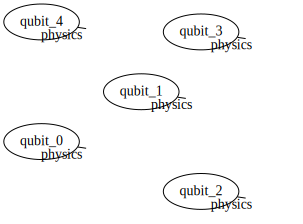

In [10]:
init_mpo = create_init_mpo(5)
to_graphviz(init_mpo)

In [11]:
class TensorGate(object):
    def __init__(self):
        self.name = None
        self.tensor = None
        self.rank = None
        self.dimension = None
        self.single = None
        self.axis_name = None
        self.dtype = tc.complex128
    def cnot(self):
        self.name = 'CNOT'
        self.tensor = tc.zeros((2, 2, 2, 2), dtype=self.dtype)  # rank-4 tensor
        # Rank-4 tensor CNOT is constructed by its truth table
        self.tensor[0, 0, 0, 0] = 1  #
        self.tensor[0, 1, 0, 1] = 1
        self.tensor[1, 0, 1, 1] = 1
        self.tensor[1, 1, 1, 0] = 1
        self.rank = 4
        self.dimension = 2
        self.single = False
        self.axis_name = ['inner_0', 'inner_1', 'physics_0', 'physics_1']
        return self
    def x(self):
        self.name = 'X'
        self.tensor = tc.tensor([[0, 1], [1, 0]], dtype=self.dtype)
        self.rank = 2
        self.dimension = 2
        self.single = True
        self.axis_name = ['inner', 'physics']
        return self
    def y(self):
        self.name = 'Y'
        self.tensor = tc.tensor([[0, -1j], [1j, 0]], dtype=self.dtype)
        self.rank = 2
        self.dimension = 2
        self.single = True
        self.axis_name = ['inner', 'physics']
        return self
    def z(self):
        self.name = 'Z'
        self.tensor = tc.tensor([[1, 0], [0, -1]], dtype=self.dtype)
        self.rank = 2
        self.dimension = 2
        self.single = True
        self.axis_name = ['inner', 'physics']
        return self
    def s(self):
        self.name = 'S'
        self.tensor = tc.tensor([[1, 0], [0, 1j]], dtype=self.dtype)
        self.rank = 2
        self.dimension = 2
        self.single = True
        self.axis_name = ['inner', 'physics']
        return self
    def t(self):
        self.name = 'T'
        self.tensor = tc.tensor([[1, 0], [0, (1 + 1j) / np.sqrt(2)]], dtype=self.dtype)
        self.rank = 2
        self.dimension = 2
        self.single = True
        self.axis_name = ['inner', 'physics']
        return self
    def h(self):
        self.name = 'H'
        self.tensor = tc.tensor([[1, 1], [1, -1]], dtype=self.dtype) / np.sqrt(2)
        self.rank = 2
        self.dimension = 2
        self.single = True
        self.axis_name = ['inner', 'physics']
        return self
    def rx(self, theta):
        self.name = 'RX'
        self.tensor = tc.tensor([[np.cos(theta / 2), -1j * np.sin(theta / 2)],
                                 [-1j * np.sin(theta / 2), np.cos(theta / 2)]], dtype=self.dtype)
        self.rank = 2
        self.dimension = 2
        self.single = True
        self.axis_name = ['inner', 'physics']
        return self
    def ry(self, theta):
        self.name = 'RY'
        self.tensor = tc.tensor([[np.cos(theta / 2), -np.sin(theta / 2)],
                                 [np.sin(theta / 2), np.cos(theta / 2)]], dtype=self.dtype)
        self.rank = 2
        self.dimension = 2
        self.single = True
        self.axis_name = ['inner', 'physics']
        return self
    def rz(self, theta):
        self.name = 'RZ'
        self.tensor = tc.tensor([[np.exp(-1j * theta / 2), 0],
                                 [0, np.exp(1j * theta / 2)]], dtype=self.dtype)
        self.rank = 2
        self.dimension = 2
        self.single = True
        self.axis_name = ['inner', 'physics']
        return self
    def u1(self, theta):
        self.name = 'U1'
        self.tensor = tc.tensor([[1, 0], [0, np.exp(1j * theta)]], dtype=self.dtype)
        self.rank = 2
        self.dimension = 2
        self.single = True
        self.axis_name = ['inner', 'physics']
        return self
    def u2(self, phi, lam):
        self.name = 'U2'
        self.tensor = tc.tensor([[1, -np.exp(1j * lam)],
                                 [np.exp(1j * phi), np.exp(1j * (phi + lam))]]) / np.sqrt(2)
        self.rank = 2
        self.dimension = 2
        self.single = True
        self.axis_name = ['inner', 'physics']
        return self
    def u3(self, theta, phi, lam):
        self.name = 'U3'
        self.tensor = tc.tensor([[np.cos(theta / 2), -np.exp(1j * lam) * np.sin(theta / 2)],
                                 [np.exp(1j * phi) * np.sin(theta / 2),
                                  np.exp(1j * (phi + lam)) * np.cos(theta / 2)]])
        self.rank = 2
        self.dimension = 2
        self.single = True
        self.axis_name = ['inner', 'physics']
        return self
    def u(self, theta, phi, lam, gamma):
        self.name = 'U'
        self.tensor = tc.tensor([[np.cos(theta / 2), -np.exp(1j * (lam + gamma)) * np.sin(theta / 2)],
                                 [np.exp(1j * (phi + gamma)) * np.sin(theta / 2),
                                  np.exp(1j * (phi + lam + gamma)) * np.cos(theta / 2)]])
        self.rank = 2
        self.dimension = 2
        self.single = True
        self.axis_name = ['inner', 'physics']
        return self
    def cz(self):
        self.name = 'CZ'
        self.tensor = tc.tensor([[1, 0, 0, 0],
                                 [0, 1, 0, 0],
                                 [0, 0, 1, 0],
                                 [0, 0, 0, -1]], dtype=self.dtype)
        self.rank = 4
        self.dimension = 2
        self.single = False
        self.axis_name = ['inner_0', 'inner_1', 'physics_0', 'physics_1']
        return self
    def swap(self):
        self.name = 'SWAP'
        self.tensor = tc.tensor([[1, 0, 0, 0],
                                 [0, 0, 1, 0],
                                 [0, 1, 0, 0],
                                 [0, 0, 0, 1]], dtype=self.dtype)
        self.tensor = tc.reshape(self.tensor, (2, 2, 2, 2))
        self.rank = 4
        self.dimension = 2
        self.single = False
        self.axis_name = ['inner_0', 'inner_1', 'physics_0', 'physics_1']
        return self

In [12]:
def is_nested(lst: list):
    return any(isinstance(i, list) for i in lst)

def qr_left2right(_qubits: list):
    # left-most rank-2 node
    _q, _r = tn.split_node_qr(_qubits[0],
                              left_edges=[_qubits[0][0]],
                              right_edges=[_qubits[0][1]],
                              left_name=_qubits[0].name)
    _r = _r @ _qubits[1]
    _r.name = 'qubit_' + str(0 + 1)
    _qubits[0], _qubits[1] = _q, _r
    # left to right rank-3 node
    for ii in range(1, len(_qubits)- 1):
        _q, _r = tn.split_node_qr(_qubits[ii], left_edges=[_qubits[ii][0], _qubits[ii][1]], right_edges=[_qubits[ii][2]], left_name=_qubits[ii].name)
        _r = _r @ _qubits[ii+1]
        _r.name = 'qubit_' + str(ii+1)
        _qubits[ii], _qubits[ii+1] = _q, _r

def get_spilt(_node, operating_qubits, method: str = 'svd'):
    """
    Split node while a double-qubit gate was applied
    :param _node: node to be split
    :param operating_qubits: operating qubits
    :param method: method to split
    :return: left node, right node, middle node
    """
    if method == 'svd':
        if _node.get_rank() == 2:
            _left, _right, _ = tn.split_node(_node,
                          left_edges=[_node[0]],
                          right_edges=[_node[1]],
                          left_name='qubit_' + str(operating_qubits[0]),
                          right_name='qubit_' + str(operating_qubits[1]),
                                             edge_name='bond')
            return _left, _right, _
        elif _node.get_rank() == 3:
            _left, _right, _ = tn.split_node(_node,
                                             left_edges=[_node[0], _node[1]],
                                                right_edges=[_node[2]],
                                                left_name='qubit_' + str(operating_qubits[0]),
                                                right_name='qubit_' + str(operating_qubits[1]),
                                             edge_name='bond')
            return _left, _right, _
def add_gate(_qubit: list, gate: TensorGate, operating_qubits: list):
    """
    Add quantum Gate to tensor network.
    :param _qubit: edges which represent qubits;
    :param gate: gate to be added;
    :param operating_qubits: operating qubits;
    :return: added gate tensor network.
    """
    if isinstance(_qubit, list) is False:
        raise TypeError('Qubit must be a list.')
    if isinstance(gate, TensorGate) is False:
        raise TypeError('Gate must be a TensorGate.')
    if isinstance(operating_qubits, list) is False:
        raise TypeError('Operating qubits must be a list.')

    single = gate.single
    if single is False:
        if is_nested(operating_qubits) is True:
            raise TypeError('Series CNOT gates are not supported yet.')
        else:
            _gate = tn.Node(gate.tensor, name=gate.name)
            _edges = []
            for i, bit in enumerate(operating_qubits):
                idx_plus = 0
                if _qubit[bit].get_rank() > 1:
                    idx_plus = 1
                _edges.append(tn.connect(_qubit[bit][0 + idx_plus], _gate[i]))
            for _edge in _edges:
                _qubit[operating_qubits[0]] = tn.contract(_edge)
            # spilt the node
            _qubit[operating_qubits[0]], _qubit[operating_qubits[1]], _ \
                = get_spilt(_qubit[operating_qubits[0]], operating_qubits)
    else:
        _gate_list = [tn.Node(gate.tensor, name=gate.name) for _ in range(len(operating_qubits))]
        for i, bit in enumerate(operating_qubits):
            tn.connect(_qubit[bit]['physics'], _gate_list[i]['inner'])
            # contract the connected edge and inherit the name of the pre-qubit
            _qubit[bit] = _qubit[bit] @ _gate_list[i]
            _qubit[bit].name = 'qubit_' + str(bit)

all_nodes = []
Gates = TensorGate()
qnumber = 5

# which generated a list of two rank-1 tensors representing the initial state |00>
qubits = create_init_mpo(qnumber)
# Apply the Hadamard gate to the first qubit
add_gate(qubits, Gates.h(), [0])
# Apply the CNOT gate to the first and second qubits
for i in range(qnumber - 1):
    add_gate(qubits, Gates.cnot(), [i, i+1])

qr_left2right(qubits)
print(qubits)

# print(tc.reshape(qubits[0].tensor, (2**qnumber, 1)))
# Contract all the nodes in the network
# result = tn.contractors.optimal(
#     all_nodes, output_edge_order=qubits
# )
# print(tc.reshape(result.tensor, (2**qnumber, 1)))

ValueError: Axis name 'inner' not found for node 'H'

In [ ]:
def svd_right2left(_qubits, chi: int = None):
    if chi is None:
        # A number who is big enough to keep all the information
        chi = 2 ** len(_qubits)
    # right-most rank-2 node
    idx = len(_qubits) - 1
    contracted_two_nodes = tn.contract_between(_qubits[idx - 1], _qubits[idx])
    _left, _right, _ = tn.split_node(contracted_two_nodes,
                                     left_edges=[contracted_two_nodes[0], contracted_two_nodes[1]],
                                     right_edges=[contracted_two_nodes[2]],
                                     left_name='qubit_' + str(idx - 1),
                                     right_name='qubit_' + str(idx), max_singular_values=chi)
    _qubits[idx - 1], _qubits[idx] = _left, _right
    # right to left rank-3 node
    for ii in range(len(_qubits) - 2, 1, -1):
        contracted_two_nodes = tn.contract_between(_qubits[ii - 1], _qubits[ii])
        _left, _right, _ = tn.split_node(contracted_two_nodes,
                                         left_edges=[contracted_two_nodes[0], contracted_two_nodes[1]],
                                         right_edges=[contracted_two_nodes[2], contracted_two_nodes[3]],
                                         left_name='qubit_' + str(ii - 1),
                                         right_name='qubit_' + str(ii), max_singular_values=chi)
        _qubits[ii - 1], _qubits[ii] = _left, _right
    # left-most rank-2 node
    contracted_two_nodes = tn.contract_between(_qubits[0], _qubits[1])
    _left, _right, _ = tn.split_node(contracted_two_nodes,
                                     left_edges=[contracted_two_nodes[0]],
                                     right_edges=[contracted_two_nodes[1], contracted_two_nodes[2]],
                                     left_name='qubit_' + str(0),
                                        right_name='qubit_' + str(1),
                                        max_singular_values=chi)
    _qubits[0], _qubits[1] = _left, _right

In [ ]:
def contract_mps(_qubits):
    op = _qubits[0]
    for i in range(1, len(_qubits)):
        op = tn.contract_between(op, _qubits[i])
    return op
a = create_init_mpo(4)
b = tn.Node(Gates.cnot().tensor)
d = tn.Node(Gates.cnot().tensor)
e = tn.Node(Gates.cnot().tensor)
add_gate(a, Gates.h(), [0])

edge1 = a[0][0] ^ b[0]
edge2 = a[1][0] ^ b[1]
c = tn.contract(edge1)
c = tn.contract(edge2)
u, vh, _ = tn.split_node(c, left_edges=[c[0]], right_edges=[c[1]], left_name=a[0].name, right_name=a[1].name)
a[0], a[1] = u, vh

edge3 = a[1][1] ^ d[0]
edge4 = a[2][0] ^ d[1]
c = tn.contract(edge3)
c = tn.contract(edge4)
left, right, _ = tn.split_node(c, left_edges=[c[0], c[1]], right_edges=[c[2]], left_name=a[1].name, right_name=a[2].name)
a[1], a[2] = left, right

edge5 = a[2][1] ^ e[0]
edge6 = a[3][0] ^ e[1]
c = tn.contract(edge5)
c = tn.contract(edge6)
left, right, _ = tn.split_node(c, left_edges=[c[0], c[1]], right_edges=[c[2]], left_name=a[2].name, right_name=a[3].name)
a[2], a[3] = left, right

qr_left2right(a)

svd_right2left(a, chi=None)
print(a)
f = contract_mps(a)

In [ ]:
tc.reshape(f.tensor, (2**4, 1))

In [ ]:
tensor_node = 1/np.sqrt(2) * tc.tensor([1. + 0.j, 1. + 0.j], dtype=tc.complex128)
upper = tn.Node(tensor_node, name='upper')
lower = tn.Node(tensor_node.T.conj(), name='lower')
p = 11e-4
error_diag = tc.diag(tc.tensor([np.sqrt(1 - 3*p /4), np.sqrt(p/4), np.sqrt(p/4), np.sqrt(p/4)], dtype=tc.complex128))
dpc = tc.tensor([[[1, 0], [0, 1]], [[0, 1], [1, 0]], [[0, -1j], [1j, 0]], [[1, 0], [0, -1]]], dtype=tc.complex128)
dpc = tc.einsum('ij, jfk->fki', error_diag, dpc)
# Set the third edge as the inner edge, which was introduced by the error_diag
    # and the first edge as the physics edge
dpc[:, :, 0]

In [ ]:
dpc_node = tn.Node(dpc, name='dpc')

In [ ]:
dpc_node

In [ ]:
edge1 = upper[0] ^ dpc_node[1]
upper = tn.contract(edge1, name=upper.name)

In [ ]:
dpc_node_dagger = tn.Node(dpc.T.conj(), name='dpc_dagger')
# reform the tensor to the order that the third edge is the inner edge, and the first edge is the physics edge
dpc_node_dagger.tensor = tc.einsum('ijk->jki', dpc_node_dagger.tensor)

In [ ]:
dpc_node_dagger

In [ ]:
edge2 = lower[0] ^ dpc_node_dagger[1]
lower = tn.contract(edge2, name=lower.name)

In [ ]:
dpc_node_dagger

In [ ]:
edge3 = upper[1] ^ lower[1]

In [ ]:
rho = tn.contract(edge3, name='rho')
rho

In [ ]:
psi = tn.Node(tc.tensor([1, 0], dtype=tc.complex128), name='psi', axis_names=['physics'])
x = tc.tensor([[0, 1], [1, 0]], dtype=tc.complex128)
x_node = tn.Node(x, name='op', axis_names=['inner', 'physics'])
# x_node.get_axis_number('physics')

In [ ]:
edge = psi['physics'] ^ x_node['inner']

In [ ]:
result = tn.contract(edge, name=psi.name, axis_names=['physics'])
result

# Below is NEW 2023.04.14

In [ ]:
import re

def sort_edges4svd(_node: tn.Node, _op_idx: list):
    """
    Sort the bond and physics edges of a node after svd.

    Args:
        _node: the node to be sorted
        _op_idx: the index of the operator in the node
    Returns:
        _left: the left edges of the node after svd
        _right: the right edges of the node after svd
    """

    def _cluster_name(_op_index: list, *args):
        """
        Cluster the edges of a node according to the operator index.

        Args:
            _op_index: the index of the operator in the node
            *args: the edges of the node
        Returns:
            _left: the names of svd left side;
            _right: the names of svd right side.
        """
        def leftORight(_op_index_: list, _bond_idx: str):
            if int(_bond_idx.split('_')[1]) < _op_index[0]:
                return 'left'
            else:
                return 'right'

        _left_, _right_ = [], []
        _bond_, _inner_, _physics_ = [], [], []
        for _i in range(len(args)):
            for _j in range(len(args[_i])):
                if args[_i][_j].startswith('bond'):
                    _bond_.append(args[_i][_j])
                elif args[_i][_j].startswith('inner'):
                    _inner_.append(args[_i][_j])
                elif args[_i][_j].startswith('physics'):
                    _physics_.append(args[_i][_j])

        _bond_.sort(), _inner_.sort(), _physics_.sort()
        if len(_bond_) == 0:
            _bond_ = [[], []]
        elif len(_bond_) == 1:
            if leftORight(_op_index, _bond_[0]) == 'left':
                _bond_ = [_bond_[0], []]
            else:
                _bond_ = [[], _bond_[0]]
        if _inner_:
            _left_ = [_bond_[0]] + [_physics_[0]] + [_inner_[0]]
            _right_ = [_inner_[1]] + [_physics_[1]] + [_bond_[1]]
        else:
            _left_ = [_bond_[0]] + [_physics_[0]]
            _right_ = [_physics_[1]] + [_bond_[1]]

        # Remove empty list which is nested in list
        _left_ = [_x for _x in _left_ if _x]
        _right_ = [_x for _x in _right_ if _x]
        print('_left_ = ', _left_)
        print('_right_ = ', _right_)
        return _left_, _right_

    print(_node.axis_names)
    _left, _right = _cluster_name(_op_idx, _node.axis_names)
    _left = [_node[name] for name in _left]
    _right = [_node[name] for name in _right]
    return _left, _right


def rename_edgeAxis(_node, _oqs: list[int]):
    """
    Rename the edge axis of a node after a double-qubit gate was applied

    Args:
        _node: the node after the gate was applied;
        _oqs: operating_qubits, the qubits that the gate was applied.
    Returns:
        _node: the node after the edge axis was renamed.
    """
    def remove_numFromPhysics(_name: list or [str]) -> list[str]:
        """
        Convert the index name of a tensor to 'physics' if it is be like 'physics_{}'.format(int).
        :param _name: list of str
        :return: list of str
        """
        def has_s_int(string):
            match = re.search(r's_\d+', string)
            return bool(match)

        if isinstance(_name, list) is False:
            raise TypeError('Input must be a list.')

        for __i, __element in enumerate(_name):
            if has_s_int(__element) is True:
                _name[__i] = 'physics'
        return _name

    for _i in _oqs:
        _node[_i].axis_names = remove_numFromPhysics(_node[_i].axis_names)
        for _j in range(_node[_i].get_rank()):
            if _node[_i][_j].is_dangling() is True:
                _node[_i]['physics'].name = 'physics'
    return _node

In [ ]:
def get_spilt(_node, _oqs: list[int]):
    """
    Split node while a double-qubit gate was applied

    Args:
        _node: the node after the gate was applied;
        _oqs: operating_qubits, the qubits that the gate was applied.
    Returns:
        _left: the left node after split;
        _right: the right node after split;
        _: the middle node after split.
    """
    _left_edges, _right_edges = sort_edges4svd(_node, _oqs)
    _left, _right, _ = tn.split_node(_node,
                                     left_edges=_left_edges,
                                     right_edges=_right_edges,
                                     left_name='qubit_' + str(_oqs[0]),
                                     right_name='qubit_' + str(_oqs[1]),
                                     edge_name='bond_{}_{}'.format(_oqs[0], _oqs[1]))
    return _left, _right, _

def add_gate_truncate(_qubits: list, _gate: TensorGate, operating_qubits: list):
    if isinstance(_qubits, list) is False:
        raise TypeError('Qubit must be a list.')
    if isinstance(_gate, TensorGate) is False:
        raise TypeError('Gate must be a TensorGate.')
    if isinstance(operating_qubits, list) is False:
        raise TypeError('Operating qubits must be a list.')
    if len(operating_qubits) != 2:
        raise NotImplementedError('Only two-qubit gates are supported currently.')

    single = _gate.single
    if single is False:
        if is_nested(operating_qubits) is True:
            raise TypeError('Series CNOT gates are not supported yet.')
        else:
            _edges = []
            _gate = tn.Node(_gate.tensor, name=_gate.name, axis_names=_gate.axis_name)
            for _i, _bit in enumerate(operating_qubits):
                _edges.append(tn.connect(_qubits[_bit]['physics'], _gate['inner_' + str(_i)]))
            # contract the connected edge and inherit the name of the pre-qubit
            for _j, _edge in enumerate(_edges[:-1]):
                _gate = tn.contract(_edges[_j], name=_gate.name)
            ##
            # Codes above are fitted for multi-qubits gate, like q>=3, but the following codes are only for two-qubits gate with the consideration of simple SVD truncation.
            ##
            # SVD truncation back to two qubits
            _left, _right, _ = get_spilt(_gate, operating_qubits)
    else:
        _gate_list = [tn.Node(_gate.tensor, name=_gate.name) for _ in range(len(operating_qubits))]
        for _i, _bit in enumerate(operating_qubits):
            tn.connect(_qubits[_bit][0], _gate_list[_i][0])
            # contract the connected edge and inherit the name of the pre-qubit
            _qubits[_bit] = _qubits[_bit] @ _gate_list[_i]
            _qubits[_bit].name = 'qubit_' + str(_bit)

In [ ]:
qubits = create_init_mpo(4)
Gates = TensorGate()
cnot_node = [tn.Node(Gates.cnot().tensor, name=Gates.cnot().name, axis_names=Gates.cnot().axis_name) for _ in range(3)]
edge_1 = tn.connect(qubits[0]['physics'], cnot_node[0]['inner_0'])
edge_2 = tn.connect(qubits[1]['physics'], cnot_node[0]['inner_1'])
edge_3 = tn.connect(qubits[2]['physics'], cnot_node[1]['inner_0'])
edge_4 = tn.connect(qubits[3]['physics'], cnot_node[1]['inner_1'])
cnot_node[0] = tn.contract(edge_1, name=cnot_node[0].name)
cnot_node[0] = tn.contract(edge_2, name=cnot_node[0].name, axis_names=['physics_0', 'physics_1'])
cnot_node[1] = tn.contract(edge_3, name=cnot_node[1].name)
cnot_node[1] = tn.contract(edge_4, name=cnot_node[1].name, axis_names=['physics_0', 'physics_1'])

In [ ]:
qubits[0], qubits[1], _ = get_spilt(cnot_node[0], [0, 1])
qubits = rename_edgeAxis(qubits, [0, 1])

In [ ]:
qubits[2], qubits[3], _ = get_spilt(cnot_node[1], [2, 3])
qubits = rename_edgeAxis(qubits, [2, 3])

In [ ]:
edge_5 = tn.connect(qubits[1]['physics'], cnot_node[2]['inner_0'])
edge_6 = tn.connect(qubits[2]['physics'], cnot_node[2]['inner_1'])
cnot_node[2] = tn.contract(edge_5, name=cnot_node[2].name)
cnot_node[2] = tn.contract(edge_6, name=cnot_node[2].name)

In [ ]:
axis_names = []
for edge in [cnot_node[2][i] for i in range(cnot_node[2].get_rank())]:
    axis_names.append(edge.name)
cnot_node[2].axis_names = axis_names

In [ ]:
def _EdgeName2AxisName(_nodes: tn.Node or list[tn.Node]):
    for _node in _nodes:
        _axis_names = []
        for _edge in [_node[i] for i in range(_node.get_rank())]:
            _axis_names.append(_edge.name)
        _node.axis_names = _axis_names

In [ ]:
qubits[1], qubits[2], _ = get_spilt(cnot_node[2], [1, 2])
qubits = rename_edgeAxis(qubits, [1, 2])

In [ ]:
qubits

In [ ]:
def leftORight(_op_index_: list, _bond_idx: str):
    if int(_bond_idx.split('_')[1]) < _op_index_[0]:
        return 'left'
    else:
        return 'right'

In [ ]:
def qr_cluster(_axis_names: list, _op_idx: list[int]):

    if len(_op_idx) != 1:
        raise ValueError('QR decomposition from left to right working with each qubit')

    _left, _right = [], []
    _physics_, _I_, _bond_ = [], [], []
    for name in _axis_names:
        if name.startswith('physics'):
            _physics_.append(name)
        elif name.startswith('I'):
            _I_.append(name)
        elif name.startswith('bond'):
            _bond_.append(name)
        else:
            raise ValueError('Invalid edge name.')
    _physics_.sort(), _I_.sort(), _bond_.sort()

    if len(_bond_) == 1:
        if _op_idx[0] != int(_bond_[0].split('_')[1]):
            raise ValueError('Bond is not compatible with the operator.')
        _bond_ = [_bond_[0], []]
    elif len(_bond_) == 2:
        if _op_idx[0] != int(_bond_[0].split('_')[1]) and _op_idx[0] != int(_bond_[0].split('_')[-1]):
            raise ValueError('Bond is not compatible with the operator.')
        if _op_idx[0] != int(_bond_[1].split('_')[1]) and _op_idx[0] != int(_bond_[1].split('_')[-1]):
            raise ValueError('Bond is not compatible with the operator.')

    if leftORight(_op_idx, _bond_[0]) == 'left':
        _left = _physics_ + _I_ + [_bond_[0]]
        _right = [_bond_[1]]
    else:
        _left = _physics_ + _I_ + [_bond_[1]]
        _right = [_bond_[0]]

    _left = [_x for _x in _left if _x]
    _right = [_x for _x in _right if _x]
    return _left, _right

In [ ]:
s0 = ['physics', 'I_0', 'bond_0_1']
s1 = ['physics', 'I_0', 'bond_1_2']
s2 = ['physics', 'I_0', 'bond_10_11', 'bond_11_12']

In [ ]:
left, right = qr_cluster(s1, [1])
print(left)
print(right)

## QR decomposition

In [262]:
q1 = tn.Node(tc.rand([2, 2, 2]), name='q1', axis_names=['bond_0_1', 'physics', 'bond_1_2'])
q2 = tn.Node(tc.rand([2, 2, 2]), name='q2', axis_names=['bond_1_2', 'physics', 'bond_2_3'])
tn.connect(q1['bond_1_2'], q2['bond_1_2'])


Edge('q1'[2] -> 'q2'[0] )

In [263]:
q1, op_q2 = tn.split_node_qr(q1, left_edges=[q1['bond_0_1'], q1['physics']], right_edges=[q1['bond_1_2']], left_name=q1.name, right_name='inter4q1', edge_name='qrbond_0_1')

In [264]:
q2 = op_q2 @ q2
q2.name = 'q2'

In [265]:
axis_names = []
for edge in [q2[i] for i in range(q2.get_rank())]:
    if 'qr' in edge.name:
        edge.name = edge.name.replace('qr', '')
    axis_names.append(edge.name)
q2.axis_names = axis_names

In [266]:
q1.axis_names

['bond_0_1', 'physics', 'qrbond_0_1']

In [267]:
q2.axis_names

['bond_0_1', 'physics', 'bond_2_3']